# HTAP - Hybrid Transactional Analytical Platform


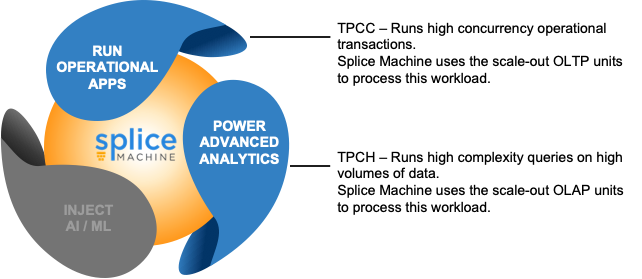

Enterprise Architects and Data Architects face significant challenges when determining which database technologies are needed to address their application and analytic needs. They have competing SLAs, some with sub-second reponse times requirements and ever growing users count, and others with large appetites for diverse and ever growing data sets. This usually leads to many databases of different forms, traditional RDBMS for applications and data warehousing technologies for the analytics. Many databases lead to data extracts, loads and transformations which need to be managed and maintained.

Splice Machine is a different kind of database. Splice Machine is an HTAP database, which means it can run transactional and analytical workloads concurrently.

In this notebook we'll review two different workloads, TPCC which requires an OLTP database to process large numbers of short transactions and TPCH which uses complex queries on large data volumes to provide analysis.

The HTAP benchmark we present in this notebook was first defined in a paper published by an international team of researchers including Andrew Pavlo who is one of our board members from Carnegie Mellon University:
- Published here: http://www.vldb.org/pvldb/vol7/p277-difallah.pdf 
- and includes original work presented by the Technical University of Munich here: https://db.in.tum.de/research/projects/CHbenCHmark/index.shtml?lang=en.

That work has been extended by implementing the benchmark for the Splice Machine database which is available here: https://github.com/splicemachine/htap-benchmark. 





### Setup
The following cell creates the database schema and restores the data from cloud storage in preparation for running the workloads.

Completing this step takes about 5 minutes.

If you logged on with user "splice", everything should work fine. If you are logged on as another user, then you'll need sufficient permissions to create a user and create a schema to prepare the environment.

The results should look like this:
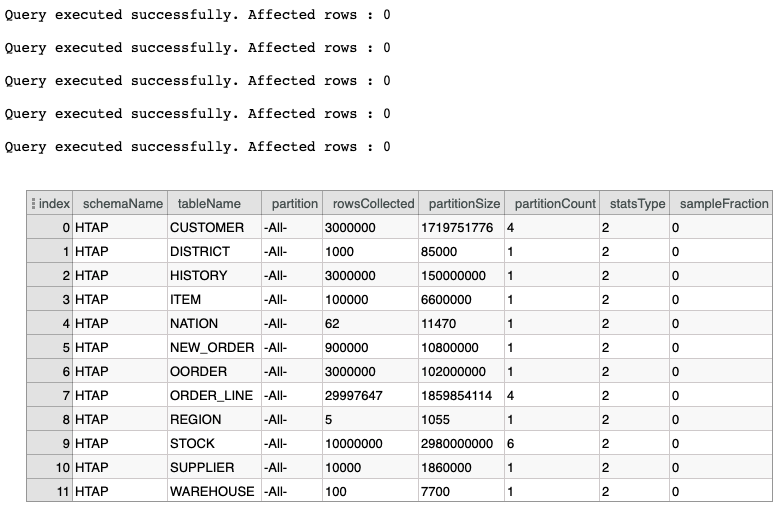

In [ ]:
%%time
%%sql

CALL SYSCS_UTIL.SYSCS_CREATE_USER('htap','htapuser');
CALL SYSCS_UTIL.SYSCS_UPDATE_SCHEMA_OWNER('htap', 'htap');
CALL SYSCS_UTIL.SYSCS_RESTORE_SCHEMA('htap', 'htap', 's3a://splice-benchmark-data/database-3.0/HTAP/100', 1271344385, false);

-- create view for Q15
SET SCHEMA htap;
CREATE VIEW revenue0 (supplier_no, total_revenue) AS
SELECT supplier_no, sum(cast(ol_amount as decimal(12,2))) AS total_revenue
FROM
  order_line,
  (SELECT s_suppkey AS supplier_no, s_i_id, s_w_id FROM stock) stocksupp
WHERE ol_i_id = s_i_id
    AND ol_supply_w_id = s_w_id
    AND ol_delivery_d >= '2007-01-02 00:00:00.000000'
GROUP BY supplier_no;
                                                  
ANALYZE SCHEMA HTAP;

## The HTAP Workload

The full workload that you'll run in the "[Running the HTAP Workloads](#run_htap)" section below, uses both TPC-C and TPC-H tests simulating 100 and 4 users respectively. 

This section goes into significant detail of what the workload is doing for the New Order transaction type in TPCC and one of the analytic queries of TPCH. If you don't want the details, click in the link above to go directly to the run. If you're still with us, let's review what each of these workloads entail in some detail:

### TPC-C 
The definition of the workload as taken from TPC.ORG:

As an OLTP system benchmark, TPC-C simulates a complete environment where a population of terminal operators executes transactions against a database. The benchmark is centered around the principal activities (transactions) of an order-entry environment. These transactions include entering and delivering orders, recording payments, checking the status of orders, and monitoring the level of stock at the warehouses. The benchmark portrays the activity of a wholesale supplier. TPC-C, however, is not limited to the activity of any particular business segment, but, rather, represents any industry that must manage, sell, or distribute a product or service.

The most frequent transaction consists of entering a new order which, on average, is comprised of ten different items. Each warehouse tries to maintain stock for the 100,000 items in the Company's catalog and fill orders from that stock. However, in reality, one warehouse will probably not have all the parts required to fill every order. Therefore, TPC-C requires that close to ten percent of all orders must be supplied by another warehouse of the Company. Another frequent transaction consists in recording a payment received from a customer. Less frequently, operators will request the status of a previously placed order, process a batch of ten orders for delivery, or query the system for potential supply shortages by examining the level of stock at the local warehouse. A total of five types of transactions, then, are used to model this business activity. The performance metric reported by TPC-C measures the number of orders that can be fully processed per minute and is expressed in tpm-C.
"

####  New Order Transaction
The following set of cells show the SQL statements that make up the New Order transaction. Intermingled with the SQL we present an example of the application logic that drives the SQL statements. In order to simplify the code presented here, we have hard coded some elements of the sample transaction, we use a single item in the order and we are keeping the order local to the same warehouse. We use BeakerX polyglot programming capabilities to provide application logic by using variable sharing across SQL and Python cells. The purpose of presenting this code is to show that the transactions being measured in the workload runs below are not just single SQL statements, but actually complex application logic with a series of select, insert and update statements that make up the transactions which are typical of such applications. 


In [ ]:
from beakerx.object import beakerx
beakerx.warehouse_id = 57  
beakerx.district_id = 1    
beakerx.customer_id = 105 

#### Get Customer and District info

In [ ]:
%%sql
SELECT C_DISCOUNT, C_LAST, C_CREDIT, W_TAX
 INTO ${customer_data}
 FROM htap.customer, htap.warehouse
 WHERE w_id = ${warehouse_id} AND c_w_id = w_id AND
 c_d_id = ${district_id} AND c_id = ${customer_id};
 
SELECT D_NEXT_O_ID, D_TAX
 INTO ${district_data}
 FROM htap.district
 WHERE d_id = ${district_id} AND d_w_id = ${warehouse_id};

In [ ]:
from beakerx.object import beakerx
customer_data = beakerx.get('customer_data')
district_data = beakerx.get('district_data')
beakerx.d_next_o_id = district_data.get("D_NEXT_O_ID")
beakerx.o_id = district_data.get("D_NEXT_O_ID")
beakerx.o_ol_cnt = 1 # order lines

#### Reserve an order id, create the order header and new_order row and check stock

In [ ]:
%%sql
-- update next order id
UPDATE htap.district SET d_next_o_id = ${d_next_o_id} + 1
 WHERE d_id = ${district_id} AND d_w_id = ${warehouse_id};
-- insert order
INSERT INTO htap.OORDER (o_id, o_d_id, o_w_id, o_c_id, o_entry_d, o_ol_cnt, o_all_local) VALUES (${o_id}, ${district_id}, ${warehouse_id}, ${customer_id}, CURRENT_TIMESTAMP, ${o_ol_cnt}, 1);
-- insert new order record
INSERT INTO htap.NEW_ORDER (no_o_id, no_d_id, no_w_id) VALUES (${o_id}, ${district_id}, ${warehouse_id});
SELECT i_id,i_price, i_name , i_data
 INTO ${item_data}
 FROM htap.item
 WHERE i_id in (800);
SELECT s_quantity, s_data,
 s_dist_01, s_dist_02, s_dist_03, s_dist_04, s_dist_05
 s_dist_06, s_dist_07, s_dist_08, s_dist_09, s_dist_10
 INTO ${stock_data}
 FROM htap.stock
 WHERE s_w_id = 57
   AND s_i_id IN (800) 
   ;

#### Per order line processing
Here, we've intentionally avoided the looping logic that would be needed for a multi-item order. We simulate a single pass of the line level logic, but this is repeated 10 times on average for the orders executed in the TPCC workload we are using.

In [ ]:
from random import randint
item_data=beakerx.get('item_data');
stock_data=beakerx.get('stock_data');
beakerx.item_data=item_data
beakerx.s_quantity=stock_data.get('S_QUANTITY')
beakerx.ol_quantity=randint(1,15)
beakerx.ol_i_id=800
beakerx.ol_number=1
if (beakerx.s_quantity > beakerx.ol_quantity):
    beakerx.s_quantity = beakerx.s_quantity - beakerx.ol_quantity;
else:
    beakerx.s_quantity = beakerx.s_quantity - beakerx.ol_quantity + 91;
beakerx.ol_amount = beakerx.ol_quantity * item_data.get('I_PRICE') * (1+customer_data.get('W_TAX')+district_data.get('D_TAX') * (1-customer_data.get('C_DISCOUNT')))
beakerx.ol_dist_info = stock_data.get('S_DIST_07')


##### Update stock and an add order line to the order:

In [ ]:
%%sql
UPDATE htap.stock SET s_quantity = ${s_quantity}
 WHERE s_i_id = ${ol_i_id}
 AND s_w_id = ${warehouse_id};
 
INSERT INTO htap.order_line (ol_o_id, ol_d_id, ol_w_id, ol_number, ol_i_id, ol_supply_w_id, ol_quantity, ol_amount, ol_dist_info)
 VALUES (${o_id}, ${district_id}, ${warehouse_id}, ${ol_number}, ${ol_i_id}, ${warehouse_id}, ${ol_quantity}, ${ol_amount}, ${ol_dist_info});

After the item level loop completes, the transaction is committed. At any point before this if there is a failure then the whole transaction is rolled back.  The following cell shows the resulting order/orderline detail of the new order that was added: 

In [ ]:
%%sql
SELECT * 
FROM htap.oorder o INNER JOIN 
     htap.order_line ol 
   ON ol.ol_w_id=o.o_w_id AND ol.ol_d_id=o.o_d_id AND ol.ol_o_id=o.o_id
 WHERE o.o_id = ${o_id} AND o_w_id = ${warehouse_id} AND o.o_d_id=${district_id};


### TPCH 

This benchmark illustrates decision support systems that examine large volumes of data, execute queries with a high degree of complexity, and give answers to critical business questions. 

#### TPCH Query Example
The analytic workload we'll be running is the set of standard TPCH benchmark queries. It simulates running 4 concurrent analytic sessions, each running all TPCH queries one after another and then starting over with query #1.

The following cell contains one of those queries. The query takes about 50 seconds to run on a small Splice Machine cluster (4 OLAP Units). A cluster configured with more OLAP units will process the query faster.
While it runs you can go back to the "DB Console" in the top right of the database dashboard to look at the stages and tasks that Spark uses to process the query.

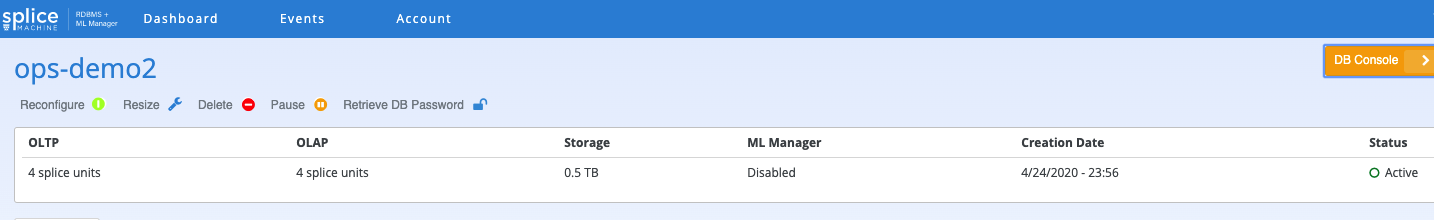

You can uncomment the EXPLAIN at the beginning of the SELECT statement to show the execution plan. Notice that in the first line, the plan contains "engine=Spark" which shows how Splice Machine is automatically selecting which engine to use when processing complex requests.



In [ ]:
%%time
%%sql

SET SCHEMA HTAP;

--EXPLAIN
SELECT su_nationkey AS supp_nation, 
      n1.n_name supp_nation_name,
      c_nationkey, 
      n2.n_name cust_nation_name,
      l_year, 
      sum(cast(ol_amount as decimal(12,2))) AS revenue 
FROM --splice-properties joinOrder=fixed
    nation n1, 
    nation n2,
    supplier, 
    stock,
    order_line,
    (select o_w_id, o_d_id, o_id, o_c_id, year(o_entry_d) as l_year from oorder) oorderyear,
    customer
WHERE ol_supply_w_id = s_w_id 
  AND ol_i_id = s_i_id 
  AND s_suppkey = su_suppkey 
  AND ol_w_id = o_w_id 
  AND ol_d_id = o_d_id 
  AND ol_o_id = o_id 
  AND c_id = o_c_id 
  AND c_w_id = o_w_id 
  AND c_d_id = o_d_id 
  AND su_nationkey = n1.n_nationkey 
  AND c_nationkey = n2.n_nationkey 
  AND (
        ( n1.n_name = 'Germany' 
          AND n2.n_name = 'Cambodia'
        ) 
      OR 
        ( n1.n_name = 'Cambodia' 
          AND n2.n_name = 'Germany')
    ) 
GROUP BY 1,2,3,4,5 
ORDER BY su_nationkey, 
        c_nationkey, 
        l_year
;


# Running the HTAP Workloads

<a id='run_htap'></a>

We'll run a combination of transactional and analytic queries as defined by the following TPC benchmarks:

- TPCC - OLTP workload using end user terminal simulations. Each simulated user processes customer orders in fast succession.
- TPCH - OLAP workload which simulates concurrent business users submitting analytic queries on the data that is actively being added by the TPCC workload.


We preconfigured the HTAP benchmark documented in https://github.com/splicemachine/htap-benchmark to run with
- 100 concurrent TPCC sessions 
- and 4 concurrect TPCH sessions.

During the execution of the workload, you can see how busy the engines are by looking at the Activity tab on the cluster dashboard.



#### Start the Workloads
Run the next cell to start the HTAP workload:

In [ ]:
# Run Parameters 
TPCC_WORKERS=100
TPCH_WORKERS=4
DURATION=300 # 5 minutes

import subprocess
import os
htaphome = os.environ['HTAP_BENCHMARK_HOME']
args = [f"{htaphome}/run_benchmark_jupyter.sh", "-m", f"{DURATION}", "-a", "none", "-t" ,f"{TPCH_WORKERS}", "-c", f"{TPCC_WORKERS}"]
popen = subprocess.Popen(args, shell=False, stdout=subprocess.PIPE)
stdoutput = popen.stdout

The next cell initializes the visualization of the HTAP workloads. The series names in the TPC-C 2 workload include a description of how many SQL statement are involved in each transaction of the type. 

Where:
* I = INSERT statements
* U = UPDATE statements
* D = DELETE statements
* S = SELECT statements

Such that (3I 2U 4S) means that the transaction uses 3 INSERTs, 2 UPDATEs and 4 SELECTs.


In [ ]:
from beakerx import CategoryBars, CategoryPlot, YAxis, Color, CategoryLines, CategoryArea,Plot, Line, CombinedPlot
import math
import time
times=list(range(0,1800,10))
tpcc = CategoryPlot( yLabel= "TPCC Transactions", showLegend=True, categoryNames= times, initWidth=1000, initHeight=300, categoryNamesLabelAngle= -1/2 * math.pi)
tpch = CategoryPlot( yLabel="TPCH Queries", categoryNames = times, initWidth=1000, initHeight=200,categoryNamesLabelAngle= -1/2 * math.pi)
lat = CategoryPlot( yLabel="Latency(ms)", categoryNames = times, initWidth=1000, initHeight=300,categoryNamesLabelAngle= -1/2 * math.pi)
l2 = [0]
l3 = [0]
l4 = [0]
l5 = [0]
l6 = [0]
tpcc.add(CategoryBars( value=[l2, l3, l4, l5, l6], seriesNames=["Delivery (3U 1D 3S)","Order Status (4S)", "Stock Level (2S)", "New Orders (3I 2U 4S)", "Payments (1I 3U 5S)"]))
l7 = [0]
tpch.add(CategoryBars( value=[l7], seriesNames=["Analytic Queries"]))

l8 =[0]
l9 =[0]
l10 =[0]
l11 =[0]
l12 =[0]
l13 =[0]
lat.add(CategoryLines( value=[l13,l12,l11,l10,l9,l8], seriesNames=["99th percentile","95th percentile", "90th percentile","75th percentile","50th percentile", "25th percentile"]))

display(tpcc,tpch,lat)


#### Monitor the Workload
The following cell updates the charts created above by parsing the output from the HTAP workload.

Given the *while(True):*, the cell will continue to run indefinitely. 

Interrupt it at any time to stop the HTAP workloads and proceed with the rest of the notebook. The workloads are set to run for 5 minutes (300 seconds). After that, interrupt it and run the following cell to get totals.

In [ ]:
%%capture
from datetime import datetime, timedelta
# scrape the workload output to get transaction counts by type, parsing lines with format: "20:15:23,683 (ThreadBench.java:299) INFO  - Monitor -> Payment/02: 17092 requests"
acount = 0
while (True):
    while (len(stdoutput.peek()) > 0): #parse stdoutput for monitor messages
        
        line = stdoutput.readline().decode('utf-8')
        print(line)
        if ("Monitor ->" in line): # only process Monitor output         
            items=line.split('>')
            txntype = items[1].strip().split(':')[0]
            if (txntype.startswith("Latencies")):
                values = items[1].strip().split(':')[1].strip().split(',') # 25=value,50=value,75=value,90=value,95=value,99=value
                l8.append(float(values[0].split("=")[1])/1000)  # 25th percentile
                l9.append(float(values[1].split("=")[1])/1000) # 50th percentile
                l10.append(float(values[2].split("=")[1])/1000) # 75th percentile
                l11.append(float(values[3].split("=")[1])/1000)  # 90th percentile
                l12.append(float(values[4].split("=")[1])/1000) # 95th percentile
                l13.append(float(values[5].split("=")[1])/1000) # 99th percentile
                display(tpcc,tpch,lat)
            else:
                value = float(items[1].strip().split(':')[1].strip().split(' ')[0])
            if (txntype.startswith("Throughput")):
                #l1.append(value*60) # calculate TpM
                l7.append(l7[-1]+acount) # only add TPCH total query count once per time cycle
            elif (txntype.startswith("Delivery")):
                acount=0 # reset acount once per cycle
                l2.append(l2[-1]+value)
            elif (txntype.startswith("OrderStatus")):
                l3.append(l3[-1]+value)
            elif (txntype.startswith("StockLevel")):
                l4.append(l4[-1]+value)
            elif (txntype.startswith("NewOrder")):
                l5.append(l5[-1]+value)
            elif (txntype.startswith("Payment")):
                l6.append(l6[-1]+value)
            elif (txntype.startswith("Q")): # accumulate TPCH query counts for all TPCH queries in a single category
                acount=acount+value
            
                


In [ ]:
# Calculate and display total counts:
tpcc_cnt = l6[-1] + l5[-1] + l4[-1] +l3[-1] +l2[-1]
tpch_cnt = l7[-1]
resp99 = sum(l13)/len(l13)
resp90 = sum(l11)/len(l11)
print( f'Total TPCC Transactions: {tpcc_cnt}')
print( f'Total TPCH Queries: {tpch_cnt}')
print( f'Avg. 99th percentile response time: {resp99}')
print( f'Avg. 90th percentile response time: {resp90}')


#### Cleanup and Reset database
Run the following cell to drop all the data, remove the HTAP schema and reclaim the space.

In [ ]:
%%time
%%sql

set schema htap;

-- drop temporary view used for processing STOCK data file
DROP VIEW revenue0;

DROP TABLE region;
DROP TABLE nation;
DROP TABLE supplier;

DROP TABLE CUSTOMER;
DROP TABLE DISTRICT;
DROP TABLE HISTORY;
DROP TABLE ITEM;
DROP TABLE NEW_ORDER;
DROP TABLE OORDER;
DROP TABLE ORDER_LINE;
DROP TABLE STOCK;
DROP TABLE WAREHOUSE;
DROP SCHEMA htap RESTRICT;                          


/* Part 2 - drop usr */

call SYSCS_UTIL.SYSCS_DROP_USER('htap');

call SYSCS_UTIL.SYSCS_UPDATE_ALL_SYSTEM_PROCEDURES();
call SYSCS_UTIL.SYSCS_EMPTY_STATEMENT_CACHE();

call SYSCS_UTIL.VACUUM();

# Conclusion
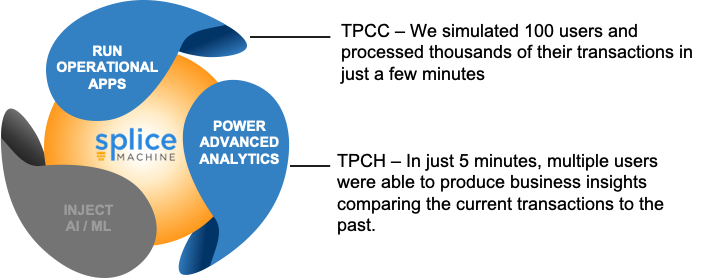


Some final thoughts:
- We've seen a real-time application processings at OLTP speed.
- We've also seen analytic workloads processing large data sets with our OLAP engine all while maintaining response times in the real-time application steady.
- We didn't see any need to move data to any other database. 
 - We read and updated a single set of tables on a single RDBMS.
 - The data is resilient and highly available on its distributed file system.
 - The CPU and memory resources for OLTP are different than the resources used for OLAP.
- The OLAP, OLTP and ML engines are separately scalable to accommodate any workload mix.
